In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import numpy as np
import pandas as pd 

# %config InlineBackend.figure_format = 'retina'

In [3]:
import sys 
sys.path.append('../src')

from spaceoracle.oracles import SpaceOracle
from spaceoracle.tools.network import MouseKidneyRegulatoryNetwork

%config InlineBackend.figure_format = 'retina'

co_grn = MouseKidneyRegulatoryNetwork()
adata = sc.read_h5ad('.cache/kidney_chip275_dim35.h5ad')
spatial_dim=35

2024-10-19 15:45:37.801419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Train model

In [4]:
so = SpaceOracle(
    adata=adata,
    annot='cluster', 
    max_epochs=5, 
    learning_rate=7e-4, 
    spatial_dim=spatial_dim,
    batch_size=256,
    rotate_maps=True,
    alpha=0.4,
    grn=co_grn
)

In [5]:
gene_kos = np.loadtxt('../data/kidney/geneKOs.txt', dtype=str)
gene_kos = [g.capitalize() for g in gene_kos]
gene_kos = sorted(set(gene_kos) & set(adata.var_names))

print(f'Genes to KO: {gene_kos}')

train_genes = co_grn.get_training_genes(co_grn.links, gene_kos)
print(f'Number of genes required to train: {len(train_genes)}')

Genes to KO: ['Bach2', 'Csf2', 'Ebf1', 'Flt3', 'Irf4', 'Pax5', 'Tcf7']
Number of genes required to train: 2288


### Initialize model

In [6]:
from spaceoracle.plotting.layout import *

# view_XYZeq_2D(adata, annot='ct2', figsize=(10,10))
view_XYZeq_3D(adata, annot='ct2', show=True, flat=False)

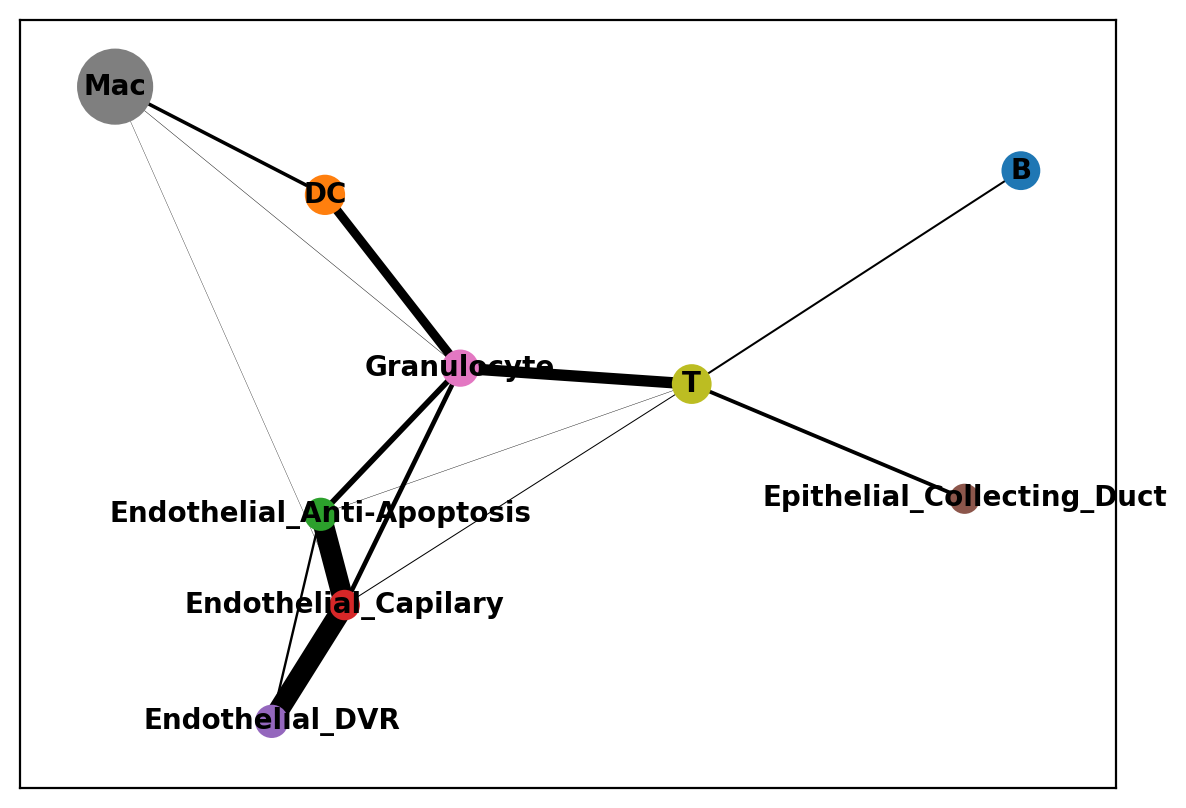

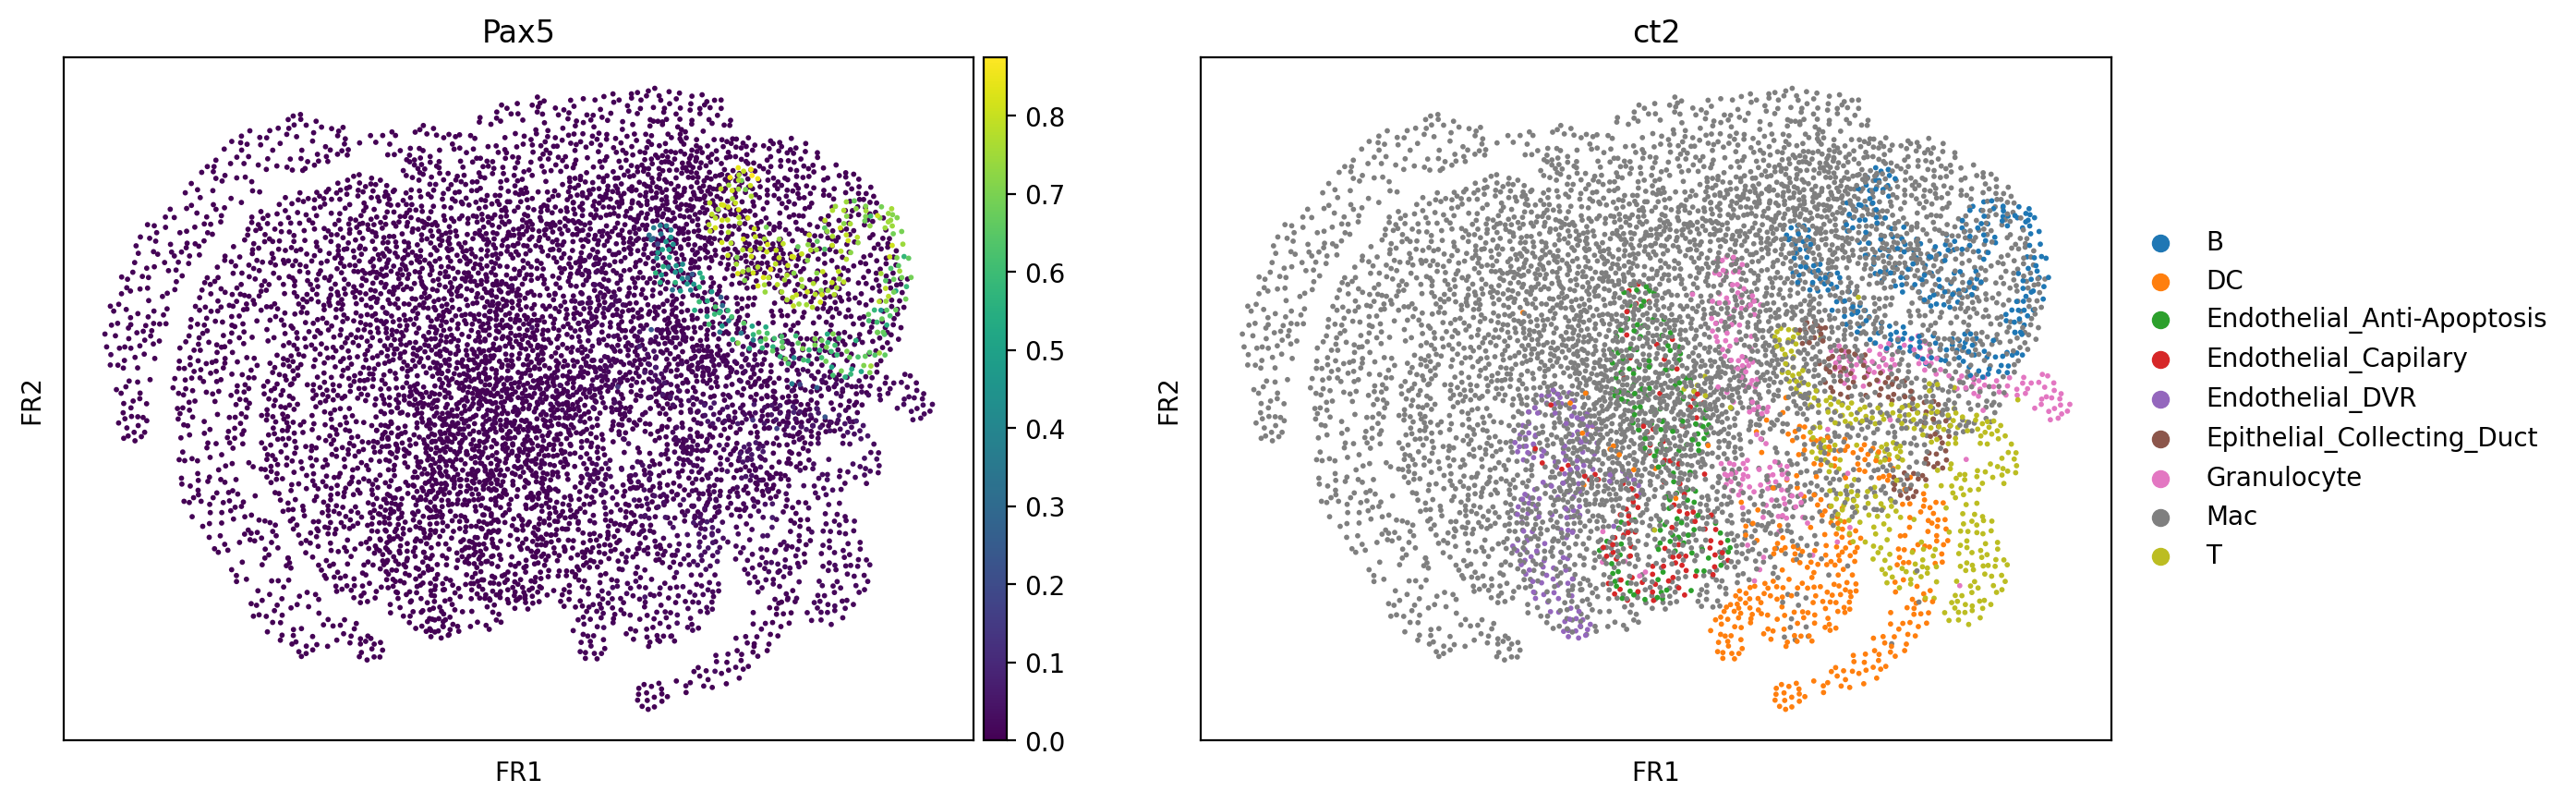

In [22]:
from spaceoracle.plotting.transitions import *

goi = 'Pax5'
compare_gex(adata, annot='ct2', goi=goi)

array([[<AxesSubplot: title={'center': 'Pax5'}>]], dtype=object)

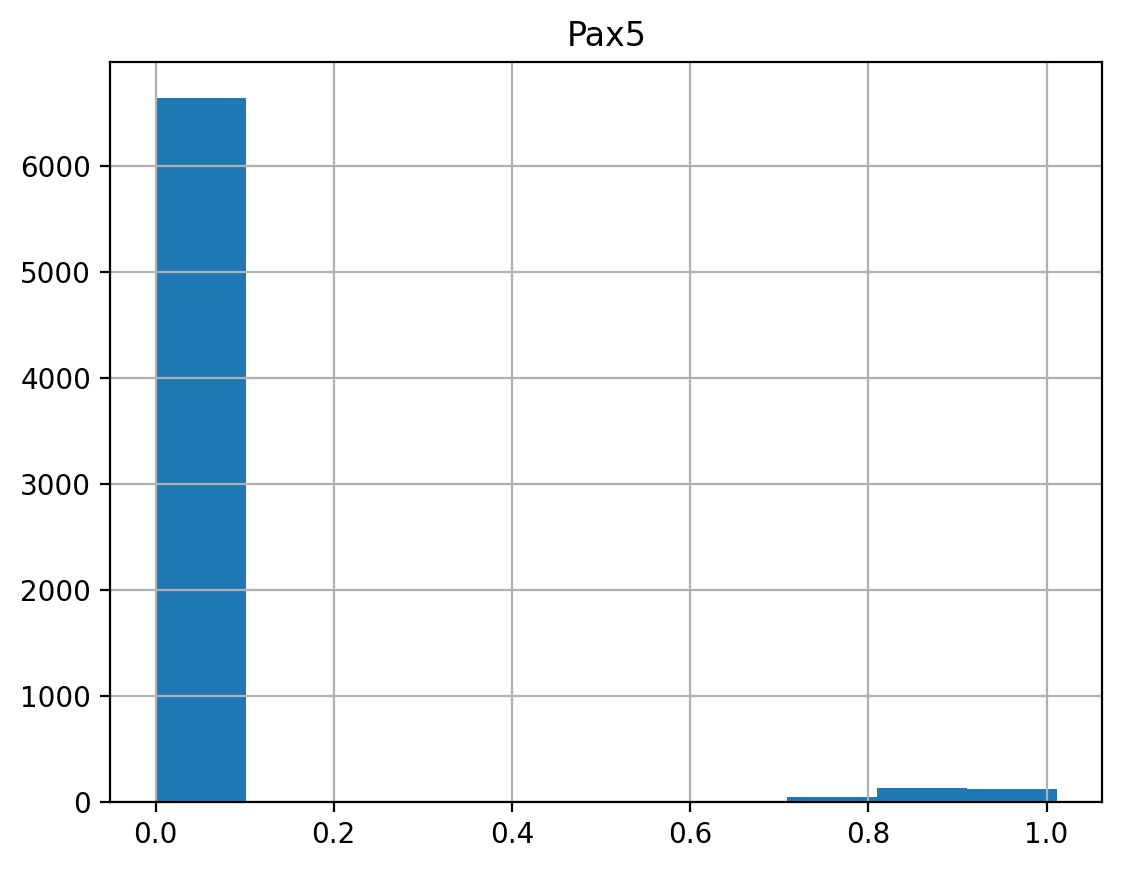

In [23]:
sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()

In [24]:
so.pcs = so.perform_PCA(so.adata)
so.knn_imputation(so.adata, so.pcs)

In [25]:
gem_simulated = so.perturb(goi, n_propagation=3, gene_expr=0)

Running simulation 3/3: 100%|██████████| 6959/6959 [00:08<00:00, 794.38it/s]


Computing vectors: 100%|██████████| 1225/1225 [00:00<00:00, 2819.38it/s]


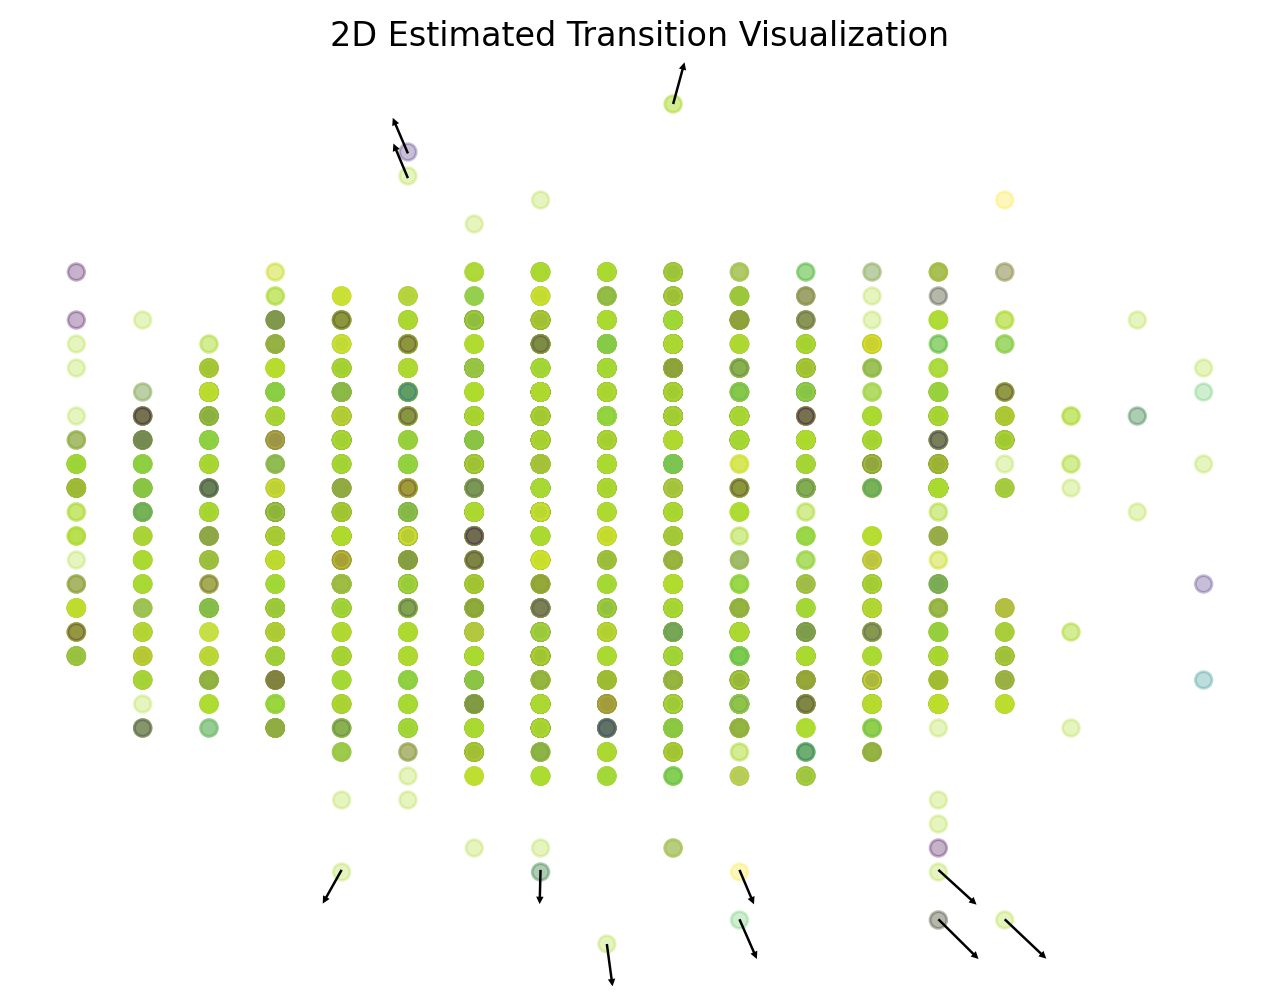

In [36]:
so.adata.obs['cluster'] = adata.obs['cluster'].astype('category')

estimate_transitions_2D(
    so.adata, so.adata.layers['delta_X'], adata.obsm['spatial'], 
    annot='cluster', grid_size=35, vector_scale=0.1, n_jobs=1)

In [50]:
celltypes = ['B', 'T']

cell_idxs = np.where(adata.obs['ct2'].isin(celltypes))[0]

adata_ct = adata[adata.obs_names[cell_idxs]]
delta_X_ct = so.adata.layers['delta_X'][cell_idxs, :]
# view_XYZeq_3D(adata_ct, annot='ct2', flat=True, show=True)

In [59]:
embedding_ct = view_XYZeq_3D(adata_ct, annot='ct2', flat=True, show=False)

estimate_transitions_3D(
    adata_ct, delta_X_ct, embedding_ct, annot='ct2', vector_scale=0.8)

Computing vectors:  62%|██████▏   | 541/870 [00:00<00:00, 1103.22it/s]

Computing vectors: 100%|██████████| 870/870 [00:00<00:00, 922.55it/s] 


In [61]:
estimate_transitions_3D(
    adata_ct, delta_X_ct, embedding_ct, annot=None, vector_scale=0.8)

Computing vectors: 100%|██████████| 870/870 [00:00<00:00, 1066.08it/s]
